# Emotion Detection

## Importing Libraries

In [5]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


## Exploring Dataset

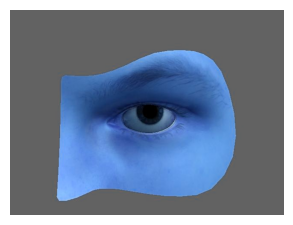

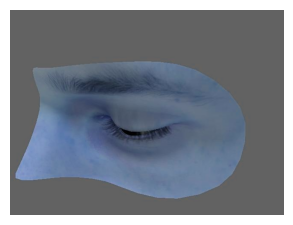

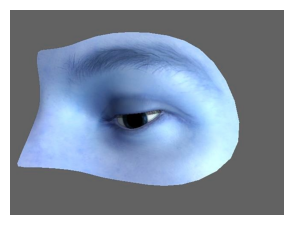

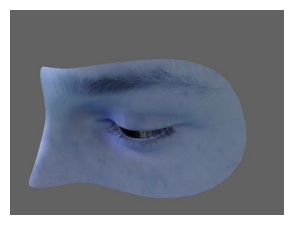

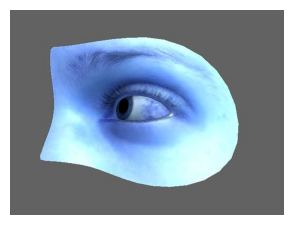

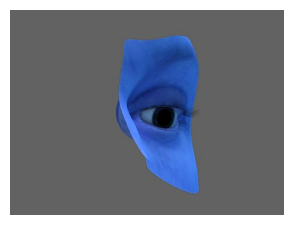

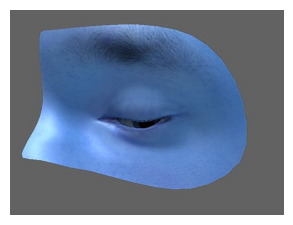

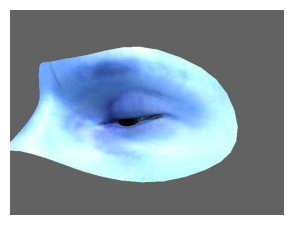

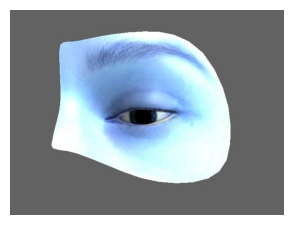

In [7]:
images = glob('/kaggle/input/openned-closed-eyes/TrainingSet/TrainingSet/*/*', recursive=True)
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

## Preparing Data for Training

In [8]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("/kaggle/input/openned-closed-eyes/TrainingSet/TrainingSet/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
datagen_train = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_train.flow_from_directory("/kaggle/input/openned-closed-eyes/TestSet/TestSet/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 1704 images belonging to 2 classes.
Found 4232 images belonging to 2 classes.


### Defining Model

In [9]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [10]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [11]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))
    conv_4 = Convolution(conv_3,512,(3,3))

    flatten = Flatten()(conv_4)

    dense_1 = Dense_f(flatten,256)
    dense_2 = Dense_f(flatten,512)

    output = Dense(2,activation = "softmax")(dense_2)
    model = Model(inputs = [inputs], outputs = [output])

    opt = Adam(lr=0.0005)
    model.compile(loss = ['categorical_crossentropy'], optimizer = opt, metrics = ['accuracy'])

    return model

In [12]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0     

### Initializing the Model

In [13]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001)
callbacks = [checkpoint,reduce_lr]

# Training the Model

In [14]:
import scipy

In [15]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15
26/26 [==============================] - ETA: 0s - loss: 0.6266 - accuracy: 0.7652
Epoch 1: saving model to model_weights.h5
26/26 [==============================] - 41s 2s/step - loss: 0.6266 - accuracy: 0.7652 - val_loss: 9.3461 - val_accuracy: 0.4825 - lr: 0.0010
Epoch 2/15
26/26 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.8750
Epoch 2: saving model to model_weights.h5
26/26 [==============================] - 28s 1s/step - loss: 0.3324 - accuracy: 0.8750 - val_loss: 2.0700 - val_accuracy: 0.5736 - lr: 0.0010
Epoch 3/15
26/26 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.8878
Epoch 3: saving model to model_weights.h5
26/26 [==============================] - 28s 1s/step - loss: 0.2711 - accuracy: 0.8878 - val_loss: 1.4911 - val_accuracy: 0.6411 - lr: 0.0010
Epoch 4/15
26/26 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.9012
Epoch 4: saving model to model_weights.h5
26/26 [=======================

### Model Evaluation

In [16]:
model.evaluate(validation_generator)

67/67 [==============================] - 19s 280ms/step - loss: 0.1595 - accuracy: 0.9409


[0.1595342755317688, 0.9409262537956238]

### Plotting Loss

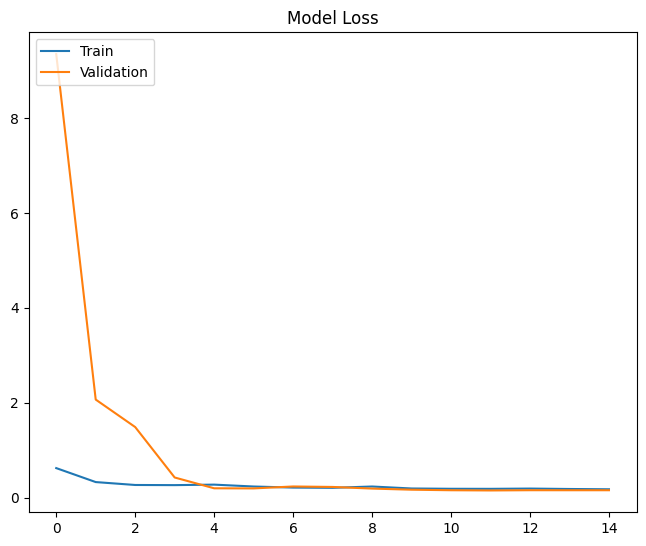

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

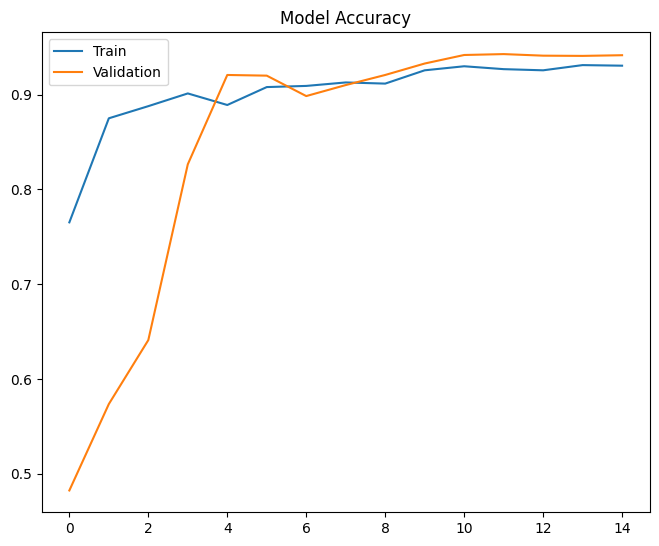

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

### Saving Model

In [19]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)